In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Infer Markov Chain transition matrix from political regime time-series data

In [2]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')

In [3]:
nCountries = len(timeSeries['country'].unique()) # numer of countries

In [4]:
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [5]:
# save the countries to a csv
#pd.DataFrame(timeSeries['country'].unique()).to_csv('countriesPolity2.csv')


# load the continent information 
counterfactuals = pd.read_csv('./../data/polity5/countriesCounterfactualPolity2.csv')


In [6]:
timeSeriesCounterfactuals = pd.merge(timeSeries, counterfactuals, on='country', how='inner')


In [7]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist'):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')["polity2"].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

def computeSteadyStateBruteForce(transitionMatrix,nSteps,initialCondition=0):
    # computes it the brutal way with iterating the transition
    
    n=transitionMatrix.shape[0] # number of Markov states
    
    if initialCondition==0:
        # if it is zero use a random vector
        x = np.random.rand(n)
        x = x / np.sum(x)
    else:
        # set it to the intial condition that we provided
        x= initialCondition
    # fo over each step
    for i in np.arange(nSteps):
        #x= P_allCountries.dot(x)
        x= x.dot(transitionMatrix)
    
    return(x)

def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


def simulateMarkovChain(transitionMatrix,initialCondition,nSteps=100):
    
    n=transitionMatrix.shape[0] # number of states
    
    stateVector=[initialCondition]
    for i in np.arange(nSteps):
        newstate = np.random.choice(np.arange(n), p=transitionMatrix[stateVector[i],:])
        stateVector.append(newstate)
    return(stateVector)
    

def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  


def createSimpleMarkovChain():
    
    P=np.zeros((2,2)) # empty transition matrix
    
    P[0,0] = 0.9
    P[0,1] = 0.1
    P[1,0] = 0.5
    P[1,1] = 0.5
    
    return(P)

## Counterfactual analysis (i.e., remove some transitions)
### No post-soviet republics

In [8]:
# remove post-soviet republics

timeSeriesCounterfactualsUSSR = timeSeriesCounterfactuals.copy()

postsovietRepublics = timeSeriesCounterfactualsUSSR[timeSeriesCounterfactualsUSSR['USSR'] == 1]['country'].unique()

timeSeriesCounterfactualsUSSR = timeSeriesCounterfactualsUSSR[~timeSeriesCounterfactualsUSSR.country.isin(postsovietRepublics)]

#for c in timeSeriesCounterfactuals[timeSeriesCounterfactuals['USSR'] == 1]['country'].unique():


In [9]:
#timeSeriesNonUSSR = timeSeriesContinent[timeSeriesContinent['Africa'] == 1]
P_allCountries_NonCollapseUSSR = estimateTransitionMatrix(timeSeriesCounterfactualsUSSR,approach='bayesian')
steadyStateEV_NonCollapseUSSR = computeSteadyStateEV(P_allCountries_NonCollapseUSSR)


# normal
P_allCountries_All = estimateTransitionMatrix(timeSeries,approach='bayesian')
steadyStateEV_All = computeSteadyStateEV(P_allCountries_All)

### A bigger Arab Spring

In [14]:
#timeSeriesCounterfactualsArabSpring.columns

In [46]:
timeSeriesCounterfactualsArabSpring = timeSeriesCounterfactuals.copy()
arabSpringCountries = timeSeriesCounterfactualsArabSpring[timeSeriesCounterfactualsArabSpring['Arab Spring'] == 1]['country'].unique()

indexArabSpringCountries = np.where(timeSeriesCounterfactualsArabSpring.country.isin(arabSpringCountries))[0]
indexPostArabSpringYear = np.where(timeSeriesCounterfactualsArabSpring.year.isin(np.arange(2011,2020)))[0]

indexIntersection = list(set(indexArabSpringCountries).intersection(set(indexPostArabSpringYear)))

timeSeriesCounterfactualsArabSpring.iloc[indexIntersection,11] = + 10


In [47]:
P_allCountries_BiggerArabSpring = estimateTransitionMatrix(timeSeriesCounterfactualsArabSpring,approach='bayesian')
steadyStateEV_ArabSpring = computeSteadyStateEV(P_allCountries_BiggerArabSpring)

#### Plot

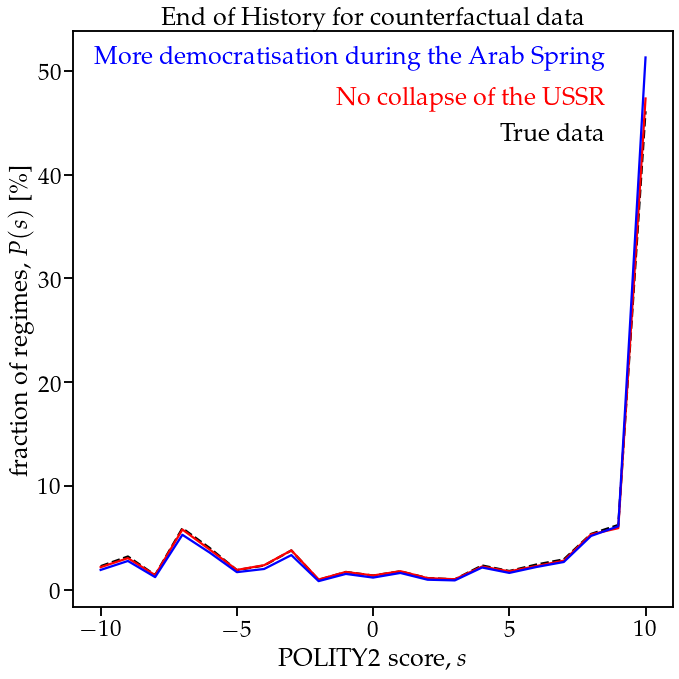

In [68]:
# set the score of post-soviet republics to -4 (which was USSR in 1989)

plt.figure(figsize=(10,10))

plt.plot(np.arange(-10,11,1),100*steadyStateEV_All,label='Worldwide', linestyle='dashed',color='k')

plt.plot(np.arange(-10,11,1),100*steadyStateEV_NonCollapseUSSR,label='without collapse USSR',color='r')

plt.plot(np.arange(-10,11,1),100*steadyStateEV_ArabSpring,label='without collapse USSR',color='b')


plt.text(8.5,0.95*100*steadyStateEV_All[-1],'True data',ha='right',va='center',color='k')
plt.text(8.5,100*steadyStateEV_NonCollapseUSSR[-1],'No collapse of the USSR',ha='right',va='center',color='r')
plt.text(8.5,100*steadyStateEV_ArabSpring[-1],'More  democratisation during the Arab Spring',ha='right',va='center',color='b')

plt.title('End of History for counterfactual data')
plt.xlabel(r'POLITY2 score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')
plt.tight_layout()
plt.savefig('./fig/FigSI-EoH_counterfactuals.pdf',bbox_inches='tight')



In [49]:
steadyStateEV_All

array([0.02269766, 0.03202634, 0.01419185, 0.05925861, 0.04026526,
       0.01886863, 0.02334233, 0.03783361, 0.00951228, 0.01710015,
       0.0136887 , 0.01768907, 0.01123888, 0.01002908, 0.02339378,
       0.01805058, 0.0243342 , 0.02924248, 0.05377164, 0.06240871,
       0.46105613])

In [50]:
steadyStateEV_NonCollapseUSSR

array([0.02173354, 0.03042291, 0.01400016, 0.05799461, 0.03872122,
       0.0190587 , 0.02362528, 0.03792499, 0.00980819, 0.01711185,
       0.01368416, 0.0178604 , 0.01115358, 0.01007378, 0.02231063,
       0.01769755, 0.02283488, 0.02798248, 0.05328488, 0.05935868,
       0.47335753])

In [51]:
steadyStateEV_ArabSpring

array([0.0190818 , 0.02769969, 0.01214363, 0.05293702, 0.03579976,
       0.01693223, 0.01998407, 0.03336933, 0.00829067, 0.01522121,
       0.01168535, 0.01615109, 0.00964165, 0.00898118, 0.02140697,
       0.01619932, 0.02191786, 0.02672169, 0.05182684, 0.06112091,
       0.51288774])

In [40]:
len(arabSpringCountries)

12

<BarContainer object of 21 artists>

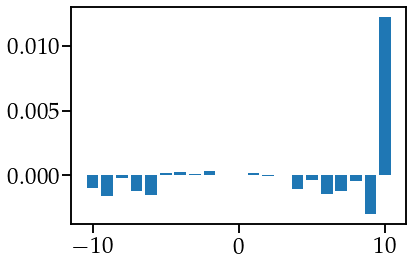

In [59]:
plt.bar(x=np.arange(-10,11),height=steadyStateEV_NonCollapseUSSR-steadyStateEV_All)

<BarContainer object of 21 artists>

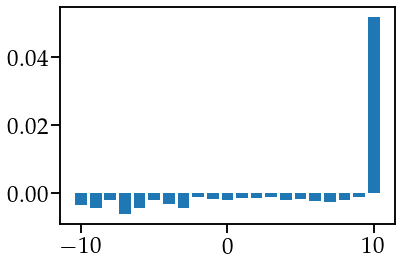

In [60]:
plt.bar(x=np.arange(-10,11),height=steadyStateEV_ArabSpring-steadyStateEV_All)